In [ ]:
import torch
torch.manual_seed(123)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data set preparation**

In [ ]:
class airfoil_dataset(Dataset):
  def __init__(self, X, y, device='cpu'):
    super(airfoil_dataset, self).__init__()
    self.X = torch.tensor(X).float().to(device)
    self.y = torch.tensor(y).float().to(device)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return self.X.shape[0]
  

class all_data():
    def __init__(self, path, transform=False):
        self.path = path
        self.data = np.load(self.path)
        if transform:
          X, self.y = self.data['X'], self.data['y']
          self.n = len(self.y)
          dim = int(np.sqrt(X.shape[1]))
          self.X = np.zeros((self.n, 1, dim, dim))
          for i in range(self.n):
            self.X[i][0] = X[i].reshape((dim, dim))
        else:
          self.X, self.y = self.data['X'], self.data['y']
          self.n = len(self.y)


    def get_train_val_test_loaders(self, train_size, val_size, batch_size, device='cpu'):
    
      all_idx = np.arange(self.n)

      for i in range(100):
          np.random.shuffle(all_idx)

      train_idx = all_idx[:int(train_size*self.n)]
      val_idx = all_idx[int(train_size*self.n):int((train_size+val_size)*self.n)]
      test_idx = all_idx[int((train_size+val_size)*self.n):]

      X_train, y_train = self.X[train_idx], self.y[train_idx]
      X_val, y_val = self.X[val_idx], self.y[val_idx]
      X_test, y_test = self.X[test_idx], self.y[test_idx]

      train_data = airfoil_dataset(X_train, y_train, device=device)
      val_data = airfoil_dataset(X_val, y_val, device=device)
      test_data = airfoil_dataset(X_test, y_test, device=device)

      train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
      
      return train_loader, val_loader, test_loader

    def get_train_val_loaders(self, train_size, batch_size, device='cpu'):
       
        all_idx = np.arange(self.n)

        for i in range(100):
            np.random.shuffle(all_idx)

        train_idx = all_idx[:int(train_size*self.n)]
        val_idx = all_idx[int(train_size*self.n):]

        X_train, y_train = self.X[train_idx], self.y[train_idx]
        X_val, y_val = self.X[val_idx], self.y[val_idx]

        train_data = airfoil_dataset(X_train, y_train, device=device)
        val_data = airfoil_dataset(X_val, y_val, device=device)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
        
        return train_loader, val_loader

# **Code to train a model (prediction)**

In [ ]:
def train(model, train_data, val_data, lr=1e-3, epochs=50):

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  all_epochs, train_losses, val_losses = np.arange(1, epochs+1), np.zeros(epochs), np.zeros(epochs)
  for epoch in range(epochs):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        predicted = model(X)
        loss = ((y - predicted)**2).sum()
        loss.backward()
        optimizer.step()

    
    
    model.eval()
    train_tot = 0.
    for X, y in train_loader:
      train_tot += X.shape[0]
      predicted = model(X)
      loss = ((y - predicted)**2).sum()
      train_losses[epoch] += loss.item()

    train_losses[epoch] /= train_tot
    
    val_tot = 0.
    for X, y in val_loader:
      val_tot += X.shape[0]
      predicted = model(X)
      loss = ((y - predicted)**2).sum()
      val_losses[epoch] += loss.item()

    val_losses[epoch] /= val_tot

  return model, all_epochs, train_losses,  val_losses

# **Predicting Lift-Drag Coefficient**

## Simple Feedforward NN

In [ ]:
torch.cuda.empty_cache()

In [ ]:
data = all_data('/content/drive/MyDrive/BML_Project/data.npz')
train_loader, val_loader, test_loader = data.get_train_val_test_loaders(0.8, 0.1, 64, device='cuda') # 80-10-10 train-val-test split

In [ ]:
ffn = torch.nn.Sequential(nn.Linear(128*128, 1024),
                            nn.ReLU(),
                            nn.BatchNorm1d(1024),
                            nn.Linear(1024, 1024),
                            nn.ReLU(),
                            nn.BatchNorm1d(1024),
                            nn.Linear(1024, 1)
                            )

ffn.to('cuda')

Sequential(
  (0): Linear(in_features=16384, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
ffn, all_epochs, train_loss, val_loss = train(model=ffn, train_data=train_loader, val_data=val_loader, lr=3e-4)

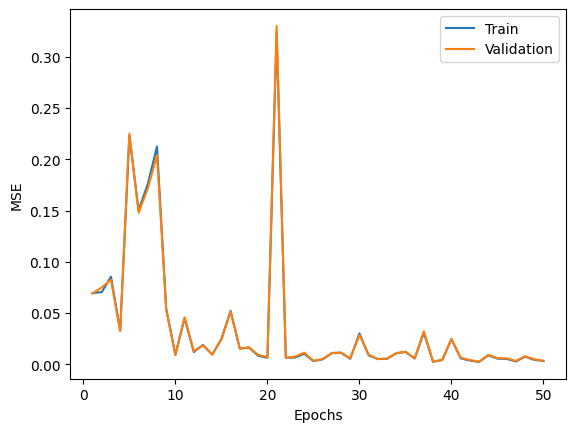

In [ ]:
plt.plot(all_epochs, train_loss, label='Train')
plt.plot(all_epochs, val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('FFN_loss.png', dpi=300)
plt.show()

In [ ]:
ffn.eval()
true_train, predicted_train = [], []
for X, y in train_loader:
  pred = ffn(X)
  true_train.extend(y.detach().cpu().numpy())
  predicted_train.extend(pred.detach().cpu().numpy())

true_val, predicted_val = [], []
for X, y in val_loader:
  pred = ffn(X)
  true_val.extend(y.detach().cpu().numpy())
  predicted_val.extend(pred.detach().cpu().numpy())

true_test, predicted_test = [], []
for X, y in test_loader:
  pred = ffn(X)
  true_test.extend(y.detach().cpu().numpy())
  predicted_test.extend(pred.detach().cpu().numpy())

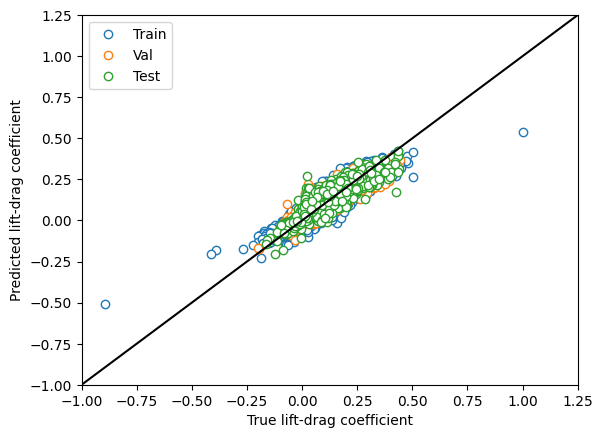

In [ ]:
plt.plot(true_train, predicted_train, 'o', label='Train', markerfacecolor='white')
plt.plot(true_val, predicted_val, 'o', label='Val',  markerfacecolor='white')
plt.plot(true_test, predicted_test, 'o', label='Test',  markerfacecolor='white')
plt.plot(np.linspace(-1, 1.25, 2, endpoint=True), np.linspace(-1, 1.25, 2, endpoint=True), color='black')
plt.xlim(-1, 1.25)
plt.ylim(-1, 1.25)
plt.legend()
plt.xlabel('True lift-drag coefficient')
plt.ylabel('Predicted lift-drag coefficient')
plt.savefig('parity_plot_ffn.png', dpi=300)
plt.show()

In [ ]:
print(np.sqrt(mse(true_train, predicted_train)))
print(np.sqrt(mse(true_val, predicted_val)))
print(np.sqrt(mse(true_test, predicted_test)))

0.05731042
0.059298325
0.06374801


In [ ]:
print(r2_score(true_train, predicted_train))
print(r2_score(true_val, predicted_val))
print(r2_score(true_test, predicted_test))

0.7719909743167488
0.7465616605852307
0.7237686911095413


## Convolutional Neural Network

In [ ]:
class DragPredictor(nn.Module):
    def __init__(self):
      super(DragPredictor, self).__init__()
      self.conv1 = nn.Conv2d(1, 8, 3, 1) # Input is 128 x 128 img
      self.conv2 = nn.Conv2d(8, 1, 3, 1) # Input is 8 x 126 x 126 img
      self.conv3 = nn.Conv2d(1, 1, 3, 1) # Input is 1 x 124 x 124 img
      self.bn1 = nn.BatchNorm2d(8)
      self.bn2 = nn.BatchNorm2d(1)
      self.bn3 = nn.BatchNorm2d(1)
      self.fc1 = nn.Linear(3721, 128)
      self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)
      x = self.bn1(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.bn2(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x = F.relu(x)
      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      return x

In [ ]:
data = all_data(path='/content/drive/MyDrive/BML_Project/data.npz', transform=True)
train_loader, val_loader, test_loader = data.get_train_val_test_loaders(0.8, 0.1, 64, device='cuda') # 80-10-10 train-val-test split

In [ ]:
cnn = DragPredictor()
cnn.to('cuda')

DragPredictor(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3721, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
cnn, all_epochs, train_loss, val_loss = train(cnn, train_loader, val_loader, lr=3e-4, epochs=20)

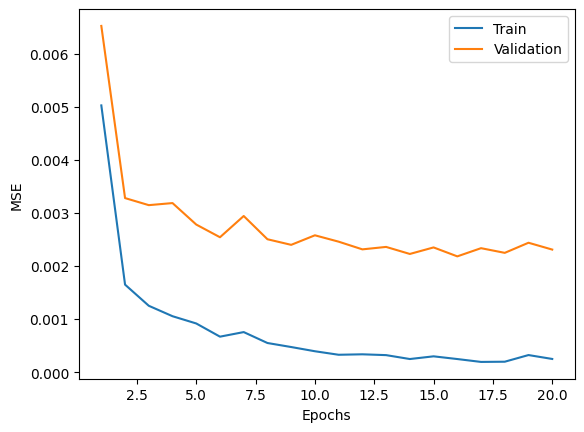

In [ ]:
plt.plot(all_epochs, train_loss, label='Train')
plt.plot(all_epochs, val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('ConvNet_loss.png', dpi=300)
plt.show()

In [ ]:
cnn.eval()
true_train, predicted_train = [], []
for X, y in train_loader:
  pred = cnn(X)
  true_train.extend(y.detach().cpu().numpy())
  predicted_train.extend(pred.detach().cpu().numpy())

true_val, predicted_val = [], []
for X, y in val_loader:
  pred = cnn(X)
  true_val.extend(y.detach().cpu().numpy())
  predicted_val.extend(pred.detach().cpu().numpy())

true_test, predicted_test = [], []
for X, y in test_loader:
  pred = cnn(X)
  true_test.extend(y.detach().cpu().numpy())
  predicted_test.extend(pred.detach().cpu().numpy())

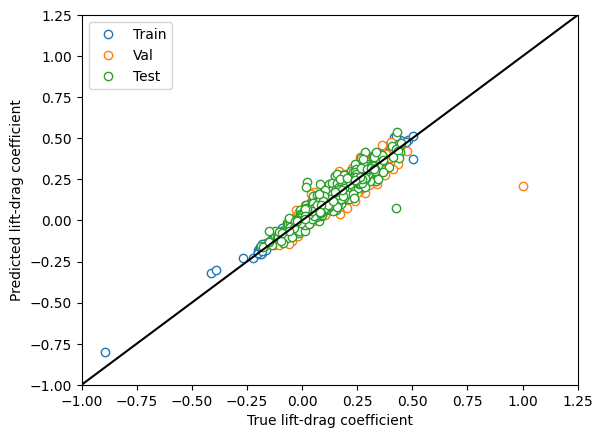

In [ ]:
plt.plot(true_train, predicted_train, 'o', label='Train', markerfacecolor='white')
plt.plot(true_val, predicted_val, 'o', label='Val',  markerfacecolor='white')
plt.plot(true_test, predicted_test, 'o', label='Test',  markerfacecolor='white')
plt.plot(np.linspace(-1, 1.25, 2, endpoint=True), np.linspace(-1, 1.25, 2, endpoint=True), color='black')
plt.xlim(-1, 1.25)
plt.ylim(-1, 1.25)
plt.legend()
plt.xlabel('True lift-drag coefficient')
plt.ylabel('Predicted lift-drag coefficient')
plt.savefig('parity_plot_convnet.png', dpi=300)
plt.show()

In [ ]:
print(np.sqrt(mse(true_train, predicted_train)))
print(np.sqrt(mse(true_val, predicted_val)))
print(np.sqrt(mse(true_test, predicted_test)))

0.01579864
0.04805025
0.040720593


In [ ]:
print(r2_score(true_train, predicted_train))
print(r2_score(true_val, predicted_val))
print(r2_score(true_test, predicted_test))

0.9827406847913464
0.8440251681129224
0.875805217289192


# Generating new Airfoils

## Using autoencoders

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(128*128, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.linear3 = nn.Linear(1024, latent_dims)

    def forward(self, z):
        z = self.linear1(z)
        z = F.relu(z)
        z = self.linear2(z)
        z = F.relu(z)
        z = self.linear3(z)
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.linear3 = nn.Linear(1024, 128*128)

    def forward(self, z):
        z = self.linear1(z)
        z = F.relu(z)
        z = self.linear2(z)
        z = F.relu(z)
        z = self.linear3(z)
        z = torch.sigmoid(z)
        return z

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
data = all_data('/content/drive/MyDrive/BML_Project/data.npz')
train_loader, val_loader = data.get_train_val_loaders(0.9, 64, device='cuda') # 90-10 train-val split

In [ ]:
latent_dims = 128
ae = Autoencoder(latent_dims).to('cuda')

In [ ]:
def train_AE(autoencoder, train_data, val_data, lr=3e-4, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    all_epochs, train_loss, val_loss =np.arange(1, epochs+1), np.zeros(epochs), np.zeros(epochs)
    for epoch in range(epochs):
        autoencoder.train()
        for x, y in train_data:
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()

        autoencoder.eval()

        train_tot = 0
        for x, y  in train_data:
          train_tot += x.shape[0]
          x_hat = autoencoder(x)
          train_loss[epoch] += ((x - x_hat)**2).sum().item()

        train_loss[epoch] /= train_tot

        val_tot = 0
        for x, y  in val_data:
          val_tot += x.shape[0]
          x_hat = autoencoder(x)
          val_loss[epoch] += ((x - x_hat)**2).sum().item()

        val_loss[epoch] /= val_tot

    return autoencoder, all_epochs, train_loss, val_loss

In [ ]:
ae, all_epochs, train_loss, val_loss = train_AE(ae, train_loader, val_loader)

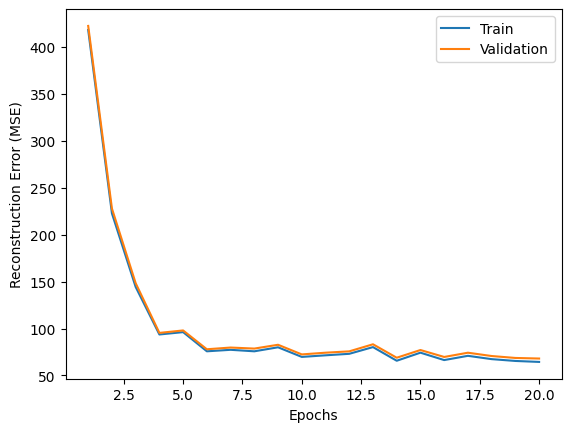

In [ ]:
plt.plot(all_epochs, train_loss, label='Train')
plt.plot(all_epochs, val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error (MSE)')
plt.savefig('AE_loss.png', dpi=300)
plt.show()

In [ ]:
train_loss[-1], val_loss[-1]

(64.42903513915343, 68.0372894554027)

In [ ]:
latent_features = np.zeros((len(train_loader), latent_dims))

for i, (x,_) in enumerate(train_loader):
  latent_features[i] = np.mean(ae.encoder(x).detach().cpu().numpy(), axis=0)

In [ ]:
mean, std = np.mean(latent_features, axis=0), np.std(latent_features, axis=0)

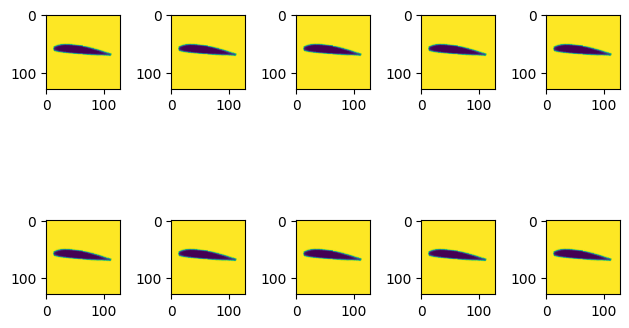

In [ ]:
# generate 10 new images:
noise = torch.Tensor(torch.randn(10, latent_dims)*std + mean).float().to('cuda')
gen_images = ae.decoder(noise)

# Plot images
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(gen_images[i].reshape((128, 128)).detach().cpu().numpy())

plt.tight_layout()
plt.savefig('generated.png', dpi=300)
plt.show()

In [ ]:
generated_images_numpy = np.zeros((10, 1, 128, 128))

for i in range(10):
  generated_images_numpy[i][0] = gen_images[i].reshape((128, 128)).detach().cpu().numpy()

generated_images_prediction = torch.Tensor(generated_images_numpy).float().to('cuda')

In [ ]:
predictions = cnn(generated_images_prediction)

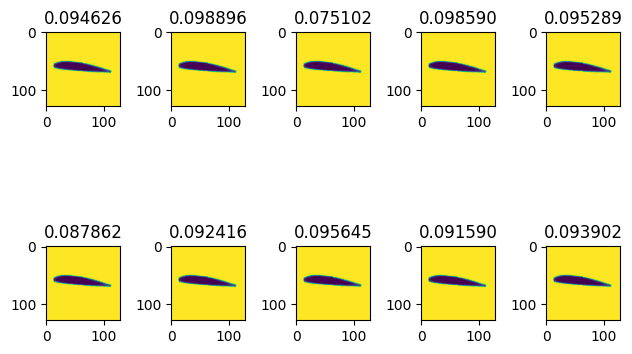

In [ ]:
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.title(f'{predictions[i].item():4f}')
  plt.imshow(gen_images[i].reshape((128, 128)).detach().cpu().numpy())

plt.tight_layout()
plt.savefig('generated_predictions.png', dpi=300)
plt.show()